C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/5 -- Text: Loss 0.5793, Acc 0.8269 | Image: Loss 0.5139, Acc 0.8254 | Audio: Loss 2.0737, Acc 0.1187
Validation -- Text: Loss 0.0001, Acc 1.0000 | Image: Loss 0.1851, Acc 0.9469 | Audio: Loss 2.0277, Acc 0.2500
Epoch 2/5 -- Text: Loss 0.0039, Acc 1.0000 | Image: Loss 0.1834, Acc 0.9407 | Audio: Loss 1.9167, Acc 0.4813
Validation -- Text: Loss 0.0000, Acc 1.0000 | Image: Loss 0.1065, Acc 0.9662 | Audio: Loss 1.6557, Acc 0.5000
Epoch 3/5 -- Text: Loss 0.1224, Acc 0.9672 | Image: Loss 0.1127, Acc 0.9635 | Audio: Loss 1.1723, Acc 0.6375
Validation -- Text: Loss 0.0577, Acc 1.0000 | Image: Loss 0.1246, Acc 0.9581 | Audio: Loss 0.7097, Acc 0.8750
Epoch 4/5 -- Text: Loss 0.1053, Acc 0.9731 | Image: Loss 0.1212, Acc 0.9631 | Audio: Loss 0.5133, Acc 0.8125
Validation -- Text: Loss 0.0018, Acc 1.0000 | Image: Loss 0.1028, Acc 0.9630 | Audio: Loss 0.3651, Acc 0.9750
Epoch 5/5 -- Text: Loss 0.0858, Acc 0.9731 | Image: Loss 0.0731, Acc 0.9786 | Audio: Loss 0.3715, Acc 0.8750
Validation -- T

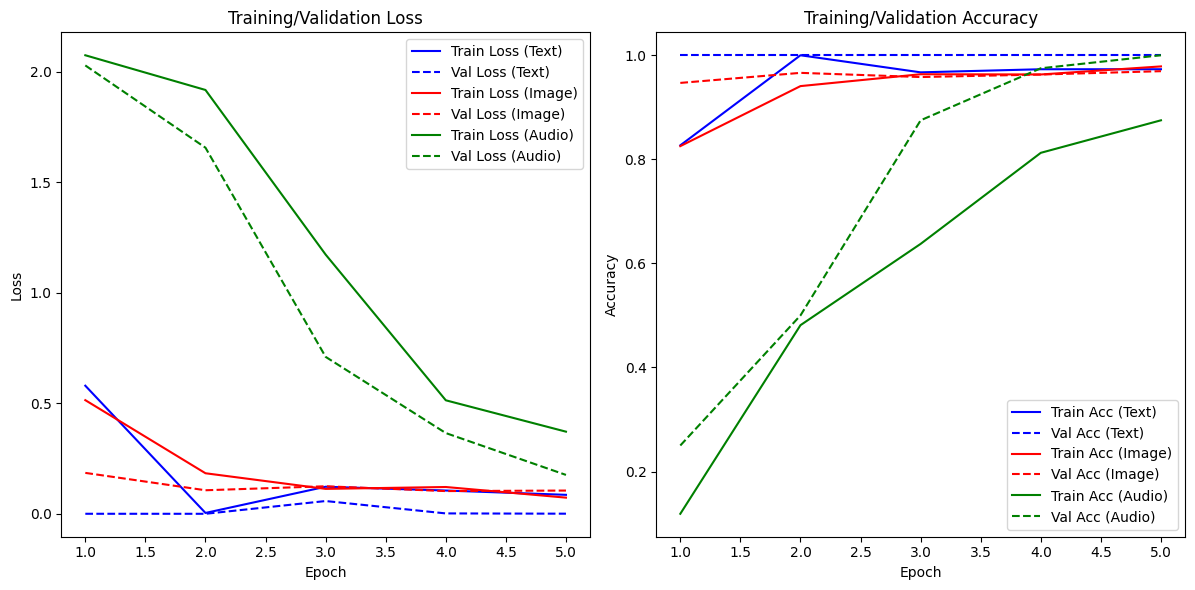

Predicted label from text: Bacterial Leaf Blight
Predicted label from image: Bacterial Leaf Blight
Predicted label from audio: Bacterial Leaf Blight
Predicted label from all modalities: Bacterial Leaf Blight


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, models
from transformers import BartModel, BartTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torchaudio

#############################################
# Custom Collate Function for Audio Dataset #
#############################################
def audio_collate_fn(batch):
    """
    Collate function for audio data.
    Each item is a tuple (waveform, label) where waveform is a 1D tensor.
    Pads all waveforms to the length of the longest in the batch.
    """
    waveforms, labels = zip(*batch)
    waveforms_padded = pad_sequence(waveforms, batch_first=True)  # shape: [B, max_length]
    labels = torch.tensor(labels)
    return waveforms_padded, labels

#############################################
# 1. Prepare the Text Dataset (CSV Data)    #
#############################################
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Remove extra batch dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Load text CSV (assumes columns "label" and "symptoms")
text_csv_path = r"F:\ABDUL\ABDUL 2024\RICE PLANT DISEASE DETECTION YOLO\FINAL SOURCE CODE\MULITEMODEL_AI\TEXT\data.csv"
text_df = pd.read_csv(text_csv_path)
label_list = text_df['label'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}
text_df['label_id'] = text_df['label'].map(label2id)

texts = text_df['symptoms'].tolist()
labels = text_df['label_id'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.33, random_state=42
)

# Initialize BART tokenizer
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)

text_train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length=128)
text_val_dataset   = TextDataset(val_texts, val_labels, tokenizer, max_length=128)
text_train_loader = DataLoader(text_train_dataset, batch_size=2, shuffle=True)
text_val_loader   = DataLoader(text_val_dataset, batch_size=2, shuffle=False)

#############################################
# 2. Prepare the Image Dataset (Folder Data)#
#############################################
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# Set image dataset paths (ImageFolder structure expected)
image_data_dir = r"F:\ABDUL\ABDUL 2024\RICE PLANT DISEASE DETECTION YOLO\FINAL SOURCE CODE\MULITEMODEL_AI\IMAGES"
image_train_dir = os.path.join(image_data_dir, "train")
image_val_dir   = os.path.join(image_data_dir, "val")

image_train_dataset = datasets.ImageFolder(image_train_dir, transform=image_transforms["train"])
image_val_dataset   = datasets.ImageFolder(image_val_dir, transform=image_transforms["val"])
image_train_loader = DataLoader(image_train_dataset, batch_size=16, shuffle=True)
image_val_loader   = DataLoader(image_val_dataset, batch_size=16, shuffle=False)

# Ensure that image classes match text classes
assert set(image_train_dataset.classes) == set(label_list), "Mismatch between text and image classes."

#############################################
# 3. Prepare the Audio Dataset (Folder Data)#
#############################################
class AudioDataset(Dataset):
    def __init__(self, audio_dir, sample_rate=16000, transform=None):
        """
        Expects audio_dir to have subfolders (one per class) containing audio files.
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.transform = transform
        self.audio_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(audio_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        for cls in self.classes:
            cls_path = os.path.join(audio_dir, cls)
            for file in os.listdir(cls_path):
                if file.lower().endswith(('.wav', '.mp3')):
                    self.audio_paths.append(os.path.join(cls_path, file))
                    self.labels.append(self.class_to_idx[cls])
                    
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        waveform = waveform.squeeze(0)  # shape: (sequence_length)
        if self.transform:
            waveform = self.transform(waveform)
        label = self.labels[idx]
        return waveform, label

# Set audio dataset paths (update as needed)
audio_data_dir = r"F:\ABDUL\ABDUL 2024\RICE PLANT DISEASE DETECTION YOLO\FINAL SOURCE CODE\MULITEMODEL_AI\AUDIO"
audio_train_dir = os.path.join(audio_data_dir, "train")
audio_val_dir   = os.path.join(audio_data_dir, "val")

audio_train_dataset = AudioDataset(audio_train_dir, sample_rate=16000, transform=None)
audio_val_dataset = AudioDataset(audio_val_dir, sample_rate=16000, transform=None)
audio_train_loader = DataLoader(audio_train_dataset, batch_size=4, shuffle=True, collate_fn=audio_collate_fn)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=4, shuffle=False, collate_fn=audio_collate_fn)

# Ensure that audio classes match text classes
assert set(audio_train_dataset.classes) == set(label_list), "Mismatch between text and audio classes."

#############################################
# 4. DeepSpeech2-Inspired Audio Model
#############################################
class DeepSpeech2AudioModel(nn.Module):
    def __init__(self, sample_rate=16000, n_mels=128, conv_out_channels=32, 
                 rnn_hidden_size=256, num_rnn_layers=3, bidirectional=True, output_dim=128):
        """
        A DeepSpeech2-inspired model that:
         - Computes a mel-spectrogram,
         - Passes it through two convolutional layers,
         - Feeds the result to a multi-layer bidirectional GRU,
         - Pools over time and projects to a fixed-dimension embedding.
        """
        super(DeepSpeech2AudioModel, self).__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
        # Two convolutional layers with stride=2 reduce time and frequency dimensions.
        self.conv = nn.Sequential(
            nn.Conv2d(1, conv_out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(),
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU()
        )
        # After two conv layers, the frequency dimension becomes approximately n_mels // 4.
        self.rnn_input_size = conv_out_channels * (n_mels // 4)
        self.rnn = nn.GRU(input_size=self.rnn_input_size,
                          hidden_size=rnn_hidden_size,
                          num_layers=num_rnn_layers,
                          batch_first=True,
                          bidirectional=bidirectional)
        rnn_output_dim = rnn_hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(rnn_output_dim, output_dim)
        
    def forward(self, waveform):
        # waveform: [batch, T]
        mel = self.melspec(waveform)  # shape: [batch, n_mels, time]
        mel = mel.unsqueeze(1)        # shape: [batch, 1, n_mels, time]
        conv_out = self.conv(mel)     # shape: [batch, conv_out_channels, new_n_mels, new_time]
        batch_size, channels, freq, time = conv_out.size()
        # Permute to shape [batch, time, channels*freq] for RNN input
        conv_out = conv_out.permute(0, 3, 1, 2)  # [batch, new_time, channels, freq]
        conv_out = conv_out.contiguous().view(batch_size, time, -1)  # [batch, new_time, channels*freq]
        rnn_out, _ = self.rnn(conv_out)  # [batch, new_time, rnn_output_dim]
        # Pool over time dimension (mean pooling)
        pooled = rnn_out.mean(dim=1)  # [batch, rnn_output_dim]
        out = self.fc(pooled)  # [batch, output_dim]
        return out

#############################################
# 5. Define the Multimodal Model Architecture
#############################################
class MultiModalClassifier(nn.Module):
    def __init__(self, text_model, image_model, audio_model,
                 text_feat_dim, image_feat_dim, audio_feat_dim,
                 hidden_dim, num_classes):
        """
        Projects features from text, image, and audio branches into a common hidden space.
        If more than one modality is provided, features are averaged before classification.
        """
        super(MultiModalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.audio_model = audio_model
        
        self.text_fc = nn.Linear(text_feat_dim, hidden_dim)
        self.image_fc = nn.Linear(image_feat_dim, hidden_dim)
        self.audio_fc = nn.Linear(audio_feat_dim, hidden_dim)
        
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, text_input=None, image_input=None, audio_input=None):
        features = None
        modality_count = 0
        
        if text_input is not None:
            # Remove the "labels" key if present
            text_input_filtered = {k: v for k, v in text_input.items() if k != "labels"}
            text_outputs = self.text_model(**text_input_filtered)
            pooled_text = text_outputs.last_hidden_state.mean(dim=1)
            text_features = self.text_fc(pooled_text)
            features = text_features if features is None else features + text_features
            modality_count += 1
            
        if image_input is not None:
            image_features = self.image_model(image_input)
            image_features = self.image_fc(image_features)
            features = image_features if features is None else features + image_features
            modality_count += 1
            
        if audio_input is not None:
            audio_features = self.audio_model(audio_input)
            audio_features = self.audio_fc(audio_features)
            features = audio_features if features is None else features + audio_features
            modality_count += 1
            
        if modality_count > 1:
            features = features / modality_count
            
        logits = self.classifier(features)
        return logits

#############################################
# 6. Instantiate the Encoders and the Model #
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text encoder: BART for feature extraction
text_encoder = BartModel.from_pretrained(model_name)
text_encoder.to(device)
text_feat_dim = text_encoder.config.d_model  # ~768

# Image encoder: Pretrained ResNet18 with final fc replaced by Identity
image_encoder = models.resnet18(pretrained=True)
num_img_features = image_encoder.fc.in_features
image_encoder.fc = nn.Identity()
image_encoder.to(device)
image_feat_dim = num_img_features  # ~512

# Audio encoder: Use our DeepSpeech2-inspired model
audio_encoder = DeepSpeech2AudioModel(sample_rate=16000, n_mels=128, conv_out_channels=32, 
                                      rnn_hidden_size=256, num_rnn_layers=3, bidirectional=True, 
                                      output_dim=128)
audio_encoder.to(device)
audio_feat_dim = 128

hidden_dim = 512
num_classes = len(label_list)

model = MultiModalClassifier(
    text_model=text_encoder,
    image_model=image_encoder,
    audio_model=audio_encoder,
    text_feat_dim=text_feat_dim,
    image_feat_dim=image_feat_dim,
    audio_feat_dim=audio_feat_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes
)
model.to(device)

#############################################
# 7. Set Up the Training Components         #
#############################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5  # Adjust as needed

# Containers for training history
train_loss_history_text = []
train_acc_history_text  = []
train_loss_history_image = []
train_acc_history_image  = []
train_loss_history_audio = []
train_acc_history_audio  = []

val_loss_history_text = []
val_acc_history_text  = []
val_loss_history_image = []
val_acc_history_image  = []
val_loss_history_audio = []
val_acc_history_audio  = []

#############################################
# 8. Training Loop (Alternating Modalities)  #
#############################################
for epoch in range(num_epochs):
    model.train()
    # --- Train on Text Data ---
    running_loss_text = 0.0
    running_correct_text = 0
    total_text_samples = 0
    for batch in text_train_loader:
        optimizer.zero_grad()
        for key in batch:
            batch[key] = batch[key].to(device)
        labels_batch = batch["labels"]
        outputs = model(text_input=batch, image_input=None, audio_input=None)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss_text += loss.item() * labels_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct_text += (preds == labels_batch).sum().item()
        total_text_samples += labels_batch.size(0)
    epoch_loss_text = running_loss_text / total_text_samples
    epoch_acc_text  = running_correct_text / total_text_samples
    train_loss_history_text.append(epoch_loss_text)
    train_acc_history_text.append(epoch_acc_text)
    
    # --- Train on Image Data ---
    running_loss_image = 0.0
    running_correct_image = 0
    total_image_samples = 0
    for images, labels_batch in image_train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(text_input=None, image_input=images, audio_input=None)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss_image += loss.item() * labels_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct_image += (preds == labels_batch).sum().item()
        total_image_samples += labels_batch.size(0)
    epoch_loss_image = running_loss_image / total_image_samples
    epoch_acc_image  = running_correct_image / total_image_samples
    train_loss_history_image.append(epoch_loss_image)
    train_acc_history_image.append(epoch_acc_image)
    
    # --- Train on Audio Data ---
    running_loss_audio = 0.0
    running_correct_audio = 0
    total_audio_samples = 0
    for waveform, labels_batch in audio_train_loader:
        optimizer.zero_grad()
        waveform = waveform.to(device)  # [B, T] (padded)
        labels_batch = labels_batch.to(device)
        outputs = model(text_input=None, image_input=None, audio_input=waveform)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss_audio += loss.item() * labels_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_correct_audio += (preds == labels_batch).sum().item()
        total_audio_samples += labels_batch.size(0)
    epoch_loss_audio = running_loss_audio / total_audio_samples
    epoch_acc_audio  = running_correct_audio / total_audio_samples
    train_loss_history_audio.append(epoch_loss_audio)
    train_acc_history_audio.append(epoch_acc_audio)
    
    print(f"Epoch {epoch+1}/{num_epochs} -- "
          f"Text: Loss {epoch_loss_text:.4f}, Acc {epoch_acc_text:.4f} | "
          f"Image: Loss {epoch_loss_image:.4f}, Acc {epoch_acc_image:.4f} | "
          f"Audio: Loss {epoch_loss_audio:.4f}, Acc {epoch_acc_audio:.4f}")
    
    # --- Validation ---
    model.eval()
    # Text validation
    val_loss_text = 0.0
    val_correct_text = 0
    total_val_text = 0
    all_text_preds = []
    all_text_labels = []
    with torch.no_grad():
        for batch in text_val_loader:
            for key in batch:
                batch[key] = batch[key].to(device)
            labels_batch = batch["labels"]
            outputs = model(text_input=batch, image_input=None, audio_input=None)
            loss = criterion(outputs, labels_batch)
            val_loss_text += loss.item() * labels_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_text_preds.extend(preds.cpu().numpy())
            all_text_labels.extend(labels_batch.cpu().numpy())
            val_correct_text += (preds == labels_batch).sum().item()
            total_val_text += labels_batch.size(0)
    avg_val_loss_text = val_loss_text / total_val_text
    avg_val_acc_text = val_correct_text / total_val_text
    val_loss_history_text.append(avg_val_loss_text)
    val_acc_history_text.append(avg_val_acc_text)
    
    # Image validation
    val_loss_image = 0.0
    val_correct_image = 0
    total_val_image = 0
    all_image_preds = []
    all_image_labels = []
    with torch.no_grad():
        for images, labels_batch in image_val_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(text_input=None, image_input=images, audio_input=None)
            loss = criterion(outputs, labels_batch)
            val_loss_image += loss.item() * labels_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_image_preds.extend(preds.cpu().numpy())
            all_image_labels.extend(labels_batch.cpu().numpy())
            val_correct_image += (preds == labels_batch).sum().item()
            total_val_image += labels_batch.size(0)
    avg_val_loss_image = val_loss_image / total_val_image
    avg_val_acc_image = val_correct_image / total_val_image
    val_loss_history_image.append(avg_val_loss_image)
    val_acc_history_image.append(avg_val_acc_image)
    
    # Audio validation
    val_loss_audio = 0.0
    val_correct_audio = 0
    total_val_audio = 0
    all_audio_preds = []
    all_audio_labels = []
    with torch.no_grad():
        for waveform, labels_batch in audio_val_loader:
            waveform = waveform.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(text_input=None, image_input=None, audio_input=waveform)
            loss = criterion(outputs, labels_batch)
            val_loss_audio += loss.item() * labels_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_audio_preds.extend(preds.cpu().numpy())
            all_audio_labels.extend(labels_batch.cpu().numpy())
            val_correct_audio += (preds == labels_batch).sum().item()
            total_val_audio += labels_batch.size(0)
    avg_val_loss_audio = val_loss_audio / total_val_audio
    avg_val_acc_audio = val_correct_audio / total_val_audio
    val_loss_history_audio.append(avg_val_loss_audio)
    val_acc_history_audio.append(avg_val_acc_audio)
    
    print(f"Validation -- Text: Loss {avg_val_loss_text:.4f}, Acc {avg_val_acc_text:.4f} | "
          f"Image: Loss {avg_val_loss_image:.4f}, Acc {avg_val_acc_image:.4f} | "
          f"Audio: Loss {avg_val_loss_audio:.4f}, Acc {avg_val_acc_audio:.4f}")

#############################################
# 9. Save the Trained Model                 #
#############################################
MODEL_SAVE_PATH = "multimodal_model.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

#############################################
# 10. Final Evaluation: Classification Reports
#############################################
print("\n=== Text Validation Classification Report ===")
print(classification_report(all_text_labels, all_text_preds, labels=list(range(len(label_list))), target_names=label_list))
print("Confusion Matrix (Text):")
print(confusion_matrix(all_text_labels, all_text_preds))

print("\n=== Image Validation Classification Report ===")
print(classification_report(all_image_labels, all_image_preds, labels=list(range(len(image_train_dataset.classes))), target_names=image_train_dataset.classes))
print("Confusion Matrix (Image):")
print(confusion_matrix(all_image_labels, all_image_preds))

print("\n=== Audio Validation Classification Report ===")
print(classification_report(all_audio_labels, all_audio_preds, labels=list(range(len(audio_train_dataset.classes))), target_names=audio_train_dataset.classes))
print("Confusion Matrix (Audio):")
print(confusion_matrix(all_audio_labels, all_audio_preds))

#############################################
# 11. Plot Training and Validation Curves   #
#############################################
epochs_arr = np.arange(1, num_epochs+1)
plt.figure(figsize=(18, 6))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(epochs_arr, train_loss_history_text, 'b-', label="Train Loss (Text)")
plt.plot(epochs_arr, val_loss_history_text, 'b--', label="Val Loss (Text)")
plt.plot(epochs_arr, train_loss_history_image, 'r-', label="Train Loss (Image)")
plt.plot(epochs_arr, val_loss_history_image, 'r--', label="Val Loss (Image)")
plt.plot(epochs_arr, train_loss_history_audio, 'g-', label="Train Loss (Audio)")
plt.plot(epochs_arr, val_loss_history_audio, 'g--', label="Val Loss (Audio)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(epochs_arr, train_acc_history_text, 'b-', label="Train Acc (Text)")
plt.plot(epochs_arr, val_acc_history_text, 'b--', label="Val Acc (Text)")
plt.plot(epochs_arr, train_acc_history_image, 'r-', label="Train Acc (Image)")
plt.plot(epochs_arr, val_acc_history_image, 'r--', label="Val Acc (Image)")
plt.plot(epochs_arr, train_acc_history_audio, 'g-', label="Train Acc (Audio)")
plt.plot(epochs_arr, val_acc_history_audio, 'g--', label="Val Acc (Audio)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#############################################
# 12. Inference Functions for the Model      #
#############################################
def inference_text(model, tokenizer, text, device, max_length=128):
    """Inference on text input only."""
    model.eval()
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    for key in encoding:
        encoding[key] = encoding[key].to(device)
    with torch.no_grad():
        logits = model(text_input=encoding, image_input=None, audio_input=None)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

def inference_image(model, image_path, transform, device):
    """Inference on image input only."""
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        logits = model(text_input=None, image_input=image, audio_input=None)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

def inference_audio(model, audio_path, device, sample_rate=16000):
    """Inference on audio input only."""
    model.eval()
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.squeeze(0).unsqueeze(0)  # add batch dimension
    waveform = waveform.to(device)
    with torch.no_grad():
        logits = model(text_input=None, image_input=None, audio_input=waveform)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

def inference_all(model, tokenizer, text, image_path, audio_path, image_transform, device, sample_rate=16000, max_length=128):
    """Inference using all three modalities."""
    model.eval()
    # Process text
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    for key in encoding:
        encoding[key] = encoding[key].to(device)
    # Process image
    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(device)
    # Process audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.squeeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(text_input=encoding, image_input=image, audio_input=waveform)
    pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

#############################################
# 13. Example Inference Usage                #
#############################################
# (Re)load tokenizer and define image transform for inference
tokenizer = BartTokenizer.from_pretrained(model_name)
image_inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Reload saved model state
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.to(device)
model.eval()

# Example inputs (update file paths as needed)
sample_text = "Yellowish to brown stripes on leaves, wilting of leaves, bacterial ooze, water-soaked lesions, leaf margins turning brown, rapid spread in humid conditions"
sample_image_path = r"F:\ABDUL\ABDUL 2024\RICE PLANT DISEASE DETECTION YOLO\FINAL SOURCE CODE\MULITEMODEL_AI\IMAGES\train\Bacterial Leaf Blight\bacterial_leaf_blight (2).jpg"
sample_audio_path = r"F:\ABDUL\ABDUL 2024\RICE PLANT DISEASE DETECTION YOLO\FINAL SOURCE CODE\MULITEMODEL_AI\AUDIO\train\Bacterial Leaf Blight\Bacterial Leaf Blight_1.wav"  # update accordingly

predicted_label_text = inference_text(model, tokenizer, sample_text, device)
print(f"Predicted label from text: {predicted_label_text}")

predicted_label_image = inference_image(model, sample_image_path, image_inference_transform, device)
print(f"Predicted label from image: {predicted_label_image}")

predicted_label_audio = inference_audio(model, sample_audio_path, device)
print(f"Predicted label from audio: {predicted_label_audio}")

predicted_label_all = inference_all(model, tokenizer, sample_text, sample_image_path, sample_audio_path, image_inference_transform, device)
print(f"Predicted label from all modalities: {predicted_label_all}")
